# Red Netto vs Black Netto

In Germany there are two supermarket chains called `Netto`.

The “red Netto” is really called `Netto Marken-Discount` with full name. They have a red-yellow logo:

![Red Netto logo](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Netto_Marken-Discount_2018_logo.svg/320px-Netto_Marken-Discount_2018_logo.svg.png)

The “black Netto” has a black-yellow logo including a dog, and is therefore sometimes called “Hundenetto” (= dog Netto).

![Black Netto logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/NettoLogo2019-S.svg/320px-NettoLogo2019-S.svg.png)

In OpenStreetMap, the proper, unambigious way to tag them are

```
brand=Netto Marken-Discount
brand:wikidata=Q879858
name=Netto Marken-Discount
shop=supermarket
```

and

```
brand=Netto
brand:wikidata=Q552652
name=Netto
shop=supermarket
```

But, since mistakes happen, sometimes the wrong brand is assigned.

This notebook checks the Netto supermarkets in OpenStreetMap against the official location information coming from the supermarkets’ websites.

In [1]:
from collections import Counter
from itertools import chain
from pathlib import Path

import contextily as ctx
import geopandas as gpd
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import overpass
import pandas as pd
import requests
import xyzservices.providers as xyz

## Download official locations from their websites

The [All The Places](https://www.alltheplaces.xyz/) project has scrapers for many store chains around the world. Thankfully they already have scrapers for both Nettos and one can simply download the results of the latest scraper run.

In [2]:
runs_history = requests.get("https://data.alltheplaces.xyz/runs/history.json").json()
latest_run = max(runs_history, key=lambda o: o["start_time"])["run_id"]
official_red_file = "netto_de.geojson"
if Path(official_red_file).exists():
    official_red = gpd.read_file(official_red_file)
else:
    official_red = gpd.read_file(f"https://alltheplaces-data.openaddresses.io/runs/{latest_run}/output/netto_de.geojson")
official_red = official_red.rename(columns={'id': 'official_id'}).set_index('official_id')
official_black_fle = "netto_salling.geojson"
if Path(official_black_fle).exists():
    official_black = gpd.read_file(official_black_fle)
else:
    official_black = gpd.read_file(f"https://alltheplaces-data.openaddresses.io/runs/{latest_run}/output/netto_salling.geojson")
official_black = official_black.rename(columns={'id': 'official_id'}).set_index('official_id')

Black Netto is present in several countries. We’re only interested in Germany here.

In [3]:
official_black = official_black[official_black["addr:country"] == "DE"].copy()

In [4]:
len(official_red)

4402

In [5]:
official_red["name"].value_counts()

name
Netto Marken-Discount      4136
Netto City                  182
Netto Getränke-Discount      84
Name: count, dtype: int64

In [6]:
len(official_black)

340

In [7]:
official_red.to_file("official_red.geojson")
official_black.to_file("official_black.geojson")

### Map of the official store locations.

Black Netto is only present in north-east Germany.

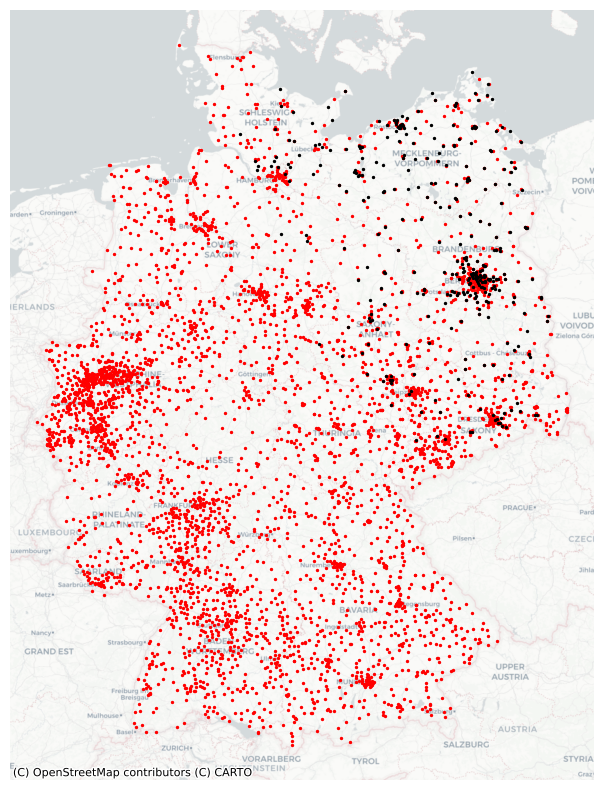

In [8]:
fig, ax = plt.subplots(figsize=(8, 10))
official_red.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=2)
official_black.to_crs(epsg=3857).plot(ax=ax, color='black', markersize=2)
ctx.add_basemap(ax, source=xyz.CartoDB.Positron)  # Add basemap
ax.set_axis_off()
plt.show()

## Download Netto supermarkets from Overpass API

In [9]:
over = overpass.API(timeout=180)
query = """
    area["name"="Deutschland"]["boundary"="administrative"]->.searchArea;
    (
        nwr["shop"="supermarket"]["name"~"^Netto"](area.searchArea);
        nwr["shop"="beverages"]["name"~"^Netto"](area.searchArea);
        nwr["shop"]["brand"="Netto"](area.searchArea);
        nwr["shop"]["brand"="Netto City"](area.searchArea);
        nwr["shop"]["brand"="Netto Marken-Discount"](area.searchArea);
        nwr["shop"]["brand"="Netto Getränke-Discount"](area.searchArea);
        nwr["shop"]["brand:wikidata"="Q552652"](area.searchArea);
        nwr["shop"]["brand:wikidata"="Q879858"](area.searchArea);
    );
"""
supermarkets = over.get(query, verbosity="meta center qt")

In [10]:
osm_supermarkets = gpd.GeoDataFrame.from_features(supermarkets, crs=4326)
osm_supermarkets

,geometry,type,id,tags,timestamp,user,uid,version,nodes
0,POINT (6.44092 49.65112),node,9131105587,"{'brand': 'Netto Marken-Discount', 'brand:wiki...",2024-10-08T16:25:22Z,CjMalone,21425661,4,NaN
1,POINT (6.56383 49.69594),node,1999212975,"{'addr:city': 'Konz', 'addr:country': 'DE', 'a...",2024-10-08T16:25:19Z,CjMalone,21425661,13,NaN
2,POINT (6.64057 49.75837),node,997832691,"{'addr:city': 'Trier', 'addr:housenumber': '15...",2024-10-08T16:25:19Z,CjMalone,21425661,17,NaN
3,POINT (7.78039 47.55671),node,727667140,"{'brand': 'Netto Marken-Discount', 'brand:wiki...",2024-10-08T16:25:19Z,CjMalone,21425661,11,NaN
4,POINT (7.57441 47.65697),node,5709577697,"{'addr:city': 'Efringen-Kirchen', 'addr:countr...",2024-10-08T16:25:22Z,CjMalone,21425661,4,NaN
...,...,...,...,...,...,...,...,...,...
4651,POINT (13.62953 54.51196),way,242685976,"{'addr:city': 'Sassnitz', 'addr:country': 'DE'...",2023-12-31T01:55:35Z,Knoblauch13,6085289,14,"[2501429477, 2501429473, 9207040831, 920704084..."
4652,POINT (11.55918 51.52135),relation,2749855,"{'addr:city': 'Lutherstadt Eisleben', 'addr:co...",2024-10-08T16:25:33Z,CjMalone,21425661,4,NaN
4653,POINT (12.11105 51.15652),relation,2628468,"{'addr:city': 'Hohenmölsen', 'addr:country': '...",2024-10-08T16:25:33Z,CjMalone,21425661,4,NaN
4654,POINT (11.9985 51.4795),relation,14334742,"{'addr:city': 'Halle (Saale)', 'addr:country':...",2024-10-08T16:25:33Z,CjMalone,21425661,2,NaN


Check the tag frequency: `brand:wikidata` is present on almost all shops!

In [11]:
with pd.option_context('display.min_rows', None):
    tag_counts = Counter(chain(*(f['properties']['tags'].keys() for f in supermarkets['features'])))
    display(pd.DataFrame.from_dict(tag_counts, orient='index', columns=["count"]).sort_values("count", ascending=False))

,count
brand:wikidata,4656
name,4656
shop,4656
brand,4656
website,4002
addr:street,3950
opening_hours,3940
addr:housenumber,3935
addr:postcode,3869
addr:city,3862


Format the DataFrame with only the columns we need for the analysis.

In [12]:
wanted_tags = ["name", "brand", "brand:wikidata", "not:brand:wikidata", "operator", "shop", "website", "contact:website"]
osm_supermarkets["osm_id"] = osm_supermarkets["type"] + "/" + osm_supermarkets["id"].astype("string")
osm_supermarkets = osm_supermarkets.set_index("osm_id").drop(columns=["id", "type", "user", "uid", "version", "nodes"])
osm_supermarkets = pd.concat([osm_supermarkets.drop(columns=["tags"]),
                              pd.json_normalize(osm_supermarkets["tags"])[wanted_tags].set_index(osm_supermarkets.index)
                             ], axis=1)
osm_supermarkets["website"] = osm_supermarkets["website"].combine_first(osm_supermarkets.pop("contact:website"))
osm_supermarkets

,geometry,timestamp,name,brand,brand:wikidata,not:brand:wikidata,operator,shop,website
osm_id,,,,,,,,,
node/9131105587,POINT (6.44092 49.65112),2024-10-08T16:25:22Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/Nittel/Wi...
node/1999212975,POINT (6.56383 49.69594),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/Konz/Wild...
node/997832691,POINT (6.64057 49.75837),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/Trier/Tre...
node/727667140,POINT (7.78039 47.55671),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/Rheinfeld...
node/5709577697,POINT (7.57441 47.65697),2024-10-08T16:25:22Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/Efringen-...
...,...,...,...,...,...,...,...,...,...
way/242685976,POINT (13.62953 54.51196),2023-12-31T01:55:35Z,Netto,Netto,Q552652,NaN,NaN,supermarket,NaN
relation/2749855,POINT (11.55918 51.52135),2024-10-08T16:25:33Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,Netto Marken-Discount GmbH & Co. oHG,supermarket,https://www.netto-online.de/filialen/Luthersta...
relation/2628468,POINT (12.11105 51.15652),2024-10-08T16:25:33Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,Netto Marken-Discount AG & Co. KG,supermarket,https://www.netto-online.de/filialen/Hohenmoel...


In [13]:
osm_supermarkets.to_file("osm_supermarkets.geojson")

## Categorize OSM supermarkets

* `red` → clearly red Netto
* `black` → clearly black Netto
* `unclear` → contradictions e.g. between name and brand

In [14]:
clearly_red = (
    (osm_supermarkets["brand:wikidata"] == "Q879858") &
    (
        (osm_supermarkets["name"].isin(("Netto", "Netto Marken-Discount", "Netto City"))) &
        (osm_supermarkets["shop"] == "supermarket")
        |
        (osm_supermarkets["name"] == "Netto Getränke-Discount") &
        (osm_supermarkets["shop"] == "beverages")
    ) &
    ((osm_supermarkets["website"].isna()) | (osm_supermarkets["website"].str.contains("netto-online.de", regex=False)))
)

In [15]:
clearly_black = (
    (osm_supermarkets["shop"] == "supermarket") &
    (osm_supermarkets["brand:wikidata"] == "Q552652") &
    (osm_supermarkets["name"].isin(["Netto", "NETTO"])) &
    ((osm_supermarkets["website"].isna()) | (osm_supermarkets["website"].str.contains("netto.de", regex=False)))
)

In [16]:
unclear = ~clearly_red & ~clearly_black
osm_supermarkets[unclear]

,geometry,timestamp,name,brand,brand:wikidata,not:brand:wikidata,operator,shop,website
osm_id,,,,,,,,,
node/660684101,POINT (6.58748 51.30502),2024-10-08T16:25:19Z,Netto City Marken-Discount,Netto City,Q879858,NaN,Netto Marken-Discount AG & Co. KG,supermarket,https://www.netto-online.de/filialen/Krefeld/K...


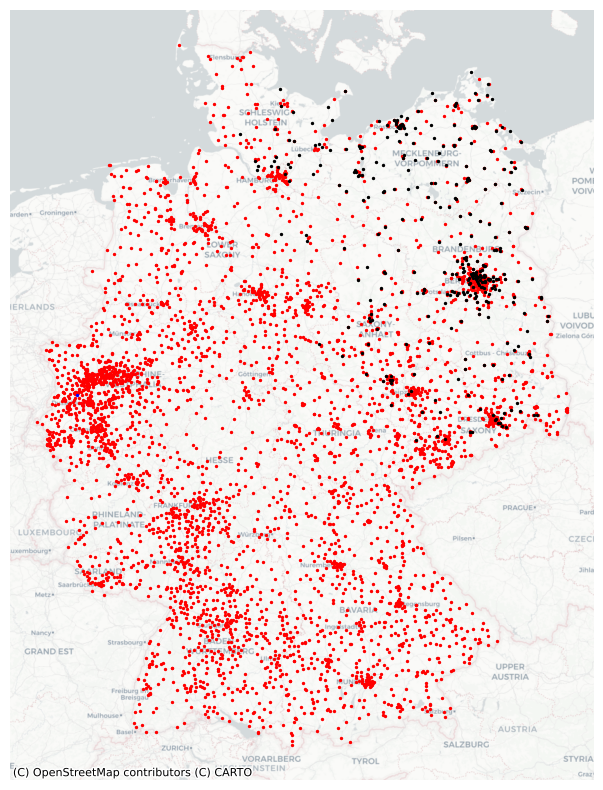

In [17]:
fig, ax = plt.subplots(figsize=(8, 10))
osm_supermarkets[clearly_red].to_crs(epsg=3857).plot(ax=ax, color='red', markersize=2)
osm_supermarkets[clearly_black].to_crs(epsg=3857).plot(ax=ax, color='black', markersize=2)
osm_supermarkets[unclear].to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=2)
ctx.add_basemap(ax, source=xyz.CartoDB.Positron)  # Add basemap
ax.set_axis_off()
plt.show()

## Join the store lists and the OSM supermarkets

* If the websites are equal, it's an immediate match
* Perform a spatial join and use the nearest point

In [18]:
official_both = pd.concat([official_red, official_black])

Many `website`s in the OSM data are tagged with upper and lower case letters like so:

https://www.netto-online.de/filialen/Nittel/Wiesenstrasse-4/2584/

But in the website data from Netto Marken-Discount, they are all lowercase.

The official values all don't end in `/`, but the URLs also work with the `/` appended.

In [19]:
osm_supermarkets["website"] = osm_supermarkets["website"].str.lower().str.replace("/$", "", regex=True)

In [20]:
website_match = pd.merge(official_both.dropna(subset=['website']).reset_index(),
                         osm_supermarkets.dropna(subset=['website']).reset_index(),
                         left_on="website", right_on="website", how="inner",
                         suffixes=("_official", "_osm"))
website_match

,official_id,ref,shop_official,@source_uri,@spider,addr:street_address,addr:city,addr:state,addr:postcode,addr:country,...,nsi_id,osm_id,geometry_osm,timestamp,name_osm,brand_osm,brand:wikidata_osm,not:brand:wikidata,operator,shop_osm
0,Z5iY-dPfsl0V3wsr_PYEWCAaqhY=,9116,supermarket,https://www.netto-online.de/filialen/moencheng...,netto_de,Engelblecker Str. 199-205,Mönchengladbach,Nordrhein-Westfalen,41066,DE,...,NaN,node/343417946,POINT (6.46891 51.21712),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket
1,xrCcL2RbKdH19t2NMHqUIrSgVXg=,9115,supermarket,https://www.netto-online.de/filialen/duesseldo...,netto_de,Vennhauser Allee 210,Düsseldorf,Nordrhein-Westfalen,40627,DE,...,NaN,node/266834599,POINT (6.86012 51.2098),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket
2,D0JEXEYOdC1_o0XMjzCaQY0VLIg=,9114,supermarket,https://www.netto-online.de/filialen/dinslaken...,netto_de,Hans-Böckler-Platz 1,Dinslaken,Nordrhein-Westfalen,46535,DE,...,NaN,node/6207047797,POINT (6.74008 51.56125),2024-10-08T16:25:22Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket
3,Ijl1He1A-Kc8cEOUKgEGZv469gw=,9113,supermarket,https://www.netto-online.de/filialen/muelheim/...,netto_de,Wissollstr. 60,Mülheim,Nordrhein-Westfalen,45478,DE,...,NaN,way/26937128,POINT (6.84636 51.42496),2024-10-08T16:25:22Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket
4,lRbWrVYlHCVpenynNxKjXOReFqo=,9112,supermarket,https://www.netto-online.de/filialen/duesseldo...,netto_de,Am Wehrhahn 33,Düsseldorf,Nordrhein-Westfalen,40211,DE,...,NaN,node/650871582,POINT (6.7903 51.22796),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,xuE_zIpTrqaXuZqIaAi_C7MzF08=,1011,supermarket,https://www.netto-online.de/filialen/regenstau...,netto_de,Straßäcker 3,Regenstauf,Bayern,93128,DE,...,NaN,way/512096279,POINT (12.12382 49.13176),2024-10-08T16:25:33Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket
4201,BI7qqwx0QCPhAy9BYMU4xgv5Ewk=,1010,supermarket,https://www.netto-online.de/filialen/seubersdo...,netto_de,Regensburger Str. 57,Seubersdorf,Bayern,92358,DE,...,NaN,node/1669441006,POINT (11.6319 49.15842),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,Netto Marken-Discount AG & Co. KG,supermarket
4202,htZfejwxQS1XC5JaryDL1eurq9c=,1007,supermarket,https://www.netto-online.de/filialen/regensbur...,netto_de,Hochweg 49,Regensburg,Bayern,93049,DE,...,NaN,way/96217100,POINT (12.0722 49.02089),2024-10-08T16:25:26Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket
4203,70w_HahumuZTcE-5h6_u75TH5zc=,1006,supermarket,https://www.netto-online.de/filialen/landshut/...,netto_de,Stethaimerstr. 41,Landshut,Bayern,84034,DE,...,NaN,way/201390505,POINT (12.15371 48.54721),2024-08-16T16:20:07Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket


The “black” Netto official store data doesn’t contain websites, unfortunately. Their website URLs contain the UUID that is used as `ref` in the official data, so it is possible to merge using that.

In [21]:
official_black['uuid'] = official_black['ref'].str.replace('-', '', regex=False)

In [22]:
osm_supermarkets[osm_supermarkets['website'].str.contains("netto.de").fillna(False)]['website'].values

/tmp/ipykernel_13025/264118408.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  osm_supermarkets[osm_supermarkets['website'].str.contains("netto.de").fillna(False)]['website'].values


array(['https://netto.de',
       'https://netto.de/geschaefte/borna/sachsenallee-26/22034eea883d4f96827df7fe5115d289',
       'https://www.netto.de',
       'https://netto.de/geschaefte/freiberg/frauensteiner-strasse-53/251c7f1c03b14ffa987106064bfd71fe',
       'https://netto.de/geschaefte/grimma/wurzener-strasse-69/eedb5ff411a4467aaa4ad49d9d5722d7',
       'https://netto.de/geschaefte/magdeburg/hermann-hesse-strasse-1a/fe475e76fb93484cb52a4608fca39e2f',
       'http://www.netto.de',
       'https://netto.de/geschaefte/brandenburg/ziesarer-landstrasse-101/e4bd9f2fb450466bb567c4c9fbab9641',
       'https://netto.de/geschaefte/brandenburg/gordenallee-206/7e6cb77e470a4af68dab9c208f8ab33d',
       'https://netto.de/geschaefte/schwielowsee/hauffstrasse-89/56f9199363774b4dae5d80628fd8c4e4',
       'https://www.netto.de',
       'https://www.netto.de/geschaefte/potsdam/breite-strasse-27/334f1ea208d248c199271fe46ba3a56d',
       'http://www.netto.de',
       'https://www.netto.de/internet/net

The URLs such as https://netto.de/geschaefte/schwedt/august-bebel-strasse-25/3ab87d12beb544af827b69f97c2e1d91 and in the UUID, just with the dashes removed.

In [23]:
osm_supermarkets["uuid"] = osm_supermarkets['website'].str.extract(r"/([0-9a-f]{32})$")

In [24]:
uuid_match = pd.merge(official_black.dropna(subset=['uuid']).reset_index(),
                         osm_supermarkets.dropna(subset=['uuid']).reset_index(),
                         left_on="uuid", right_on="uuid", how="inner",
                         suffixes=("_official", "_osm")).drop(columns=["uuid"])
uuid_match

,official_id,ref,@source_uri,@spider,shop_official,addr:street_address,addr:city,addr:postcode,addr:country,name_official,...,osm_id,geometry_osm,timestamp,name_osm,brand_osm,brand:wikidata_osm,not:brand:wikidata,operator,shop_osm,website
0,_A9IOAatSseGMC8Sm1v2695ywnE=,0717af04-5f2c-4c1c-b815-be42c73a3fbd,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Lindenstrasse 28,Neubrandenburg,17033,DE,Netto,...,way/92035583,POINT (13.26282 53.53783),2023-05-03T00:13:38Z,Netto,Netto,Q552652,NaN,Netto ApS & Co. KG,supermarket,https://netto.de/geschaefte/neubrandenburg/lin...
1,mRkbsHRS8vn7UZP8nMhr1boqy5g=,aa474ff7-56f8-4329-bc63-3516ea68998d,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Sponholzer Str. 6,Neubrandenburg,17034,DE,Netto,...,node/3669823231,POINT (13.28367 53.56136),2023-11-22T18:25:19Z,Netto,Netto,Q552652,NaN,Netto ApS & Co. KG,supermarket,https://netto.de/geschaefte/neubrandenburg/spo...
2,PTj_g_LEPbnUIUrl1KjSfNfKivE=,79efd473-c50a-40d6-99b3-613dd69e8509,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Max-Adrion-Straße 6,Neubrandenburg,17034,DE,Netto,...,way/116397096,POINT (13.2793 53.57562),2024-02-10T18:11:32Z,Netto,Netto,Q552652,NaN,Netto ApS & Co. KG,supermarket,https://netto.de/geschaefte/neubrandenburg/max...
3,4hEs3CvY7oImnvcBXHbe81jV1Rg=,9de03554-1115-4078-9b86-82b4a4831006,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Bürgermeister-Haupt-Straße 31a,Wismar,23966,DE,Netto,...,node/374272871,POINT (11.44838 53.88535),2025-02-10T07:51:25Z,Netto,Netto,Q552652,NaN,NaN,supermarket,https://netto.de/geschaefte/wismar/burgermeist...
4,trH462MRY7MStTecFsoZM4uqpK8=,772a714f-9832-4e2f-8565-d86df3e7f079,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Bahnhofplatz 5,Penzlin,17217,DE,Netto,...,way/220726609,POINT (13.08534 53.5073),2023-08-30T22:16:16Z,Netto,Netto,Q552652,NaN,Netto ApS & Co. KG,supermarket,https://netto.de/geschaefte/penzlin/bahnhofpla...
5,rbpK-vjg0EWLUUpVUEkWTuk-8jA=,da80576c-f437-4835-85d1-118684b488d2,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Adolf-Bytzeck-Straße 6,Eggesin,17367,DE,Netto,...,node/449581320,POINT (14.08701 53.6769),2025-02-10T07:44:23Z,Netto,Netto,Q552652,NaN,NaN,supermarket,https://netto.de/geschaefte/eggesin/adolf-bytz...
6,3DSJqCBY928H3LX-TFCAljha6HQ=,a613cad9-a9e4-4224-be57-ec4700e49a32,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,K.-Wagner-Straße 51,Neustrelitz,17235,DE,Netto,...,node/304330897,POINT (13.0875 53.35531),2025-02-10T07:46:09Z,Netto,Netto,Q552652,NaN,NaN,supermarket,https://netto.de/geschaefte/neustrelitz/k-wagn...
7,Sdao7KqXiFTXQ6V5b1u31fXrARY=,74a95cec-f799-4a1c-86de-0b37f0467264,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Heinrich-Heine-Straße 77,Grimmen,18507,DE,Netto,...,way/188173692,POINT (13.0382 54.10754),2025-02-21T23:00:06Z,Netto,Netto,Q552652,NaN,NaN,supermarket,https://netto.de/geschaefte/grimmen/heinrich-h...
8,4frQ84ICJUBDxc-phSA2dATXGAM=,59616e5a-5592-4ecb-8244-369113a6d1d1,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Ziolkowskistraße 2,Neubrandenburg,17036,DE,Netto,...,node/311949693,POINT (13.29508 53.5528),2021-05-24T20:27:18Z,Netto,Netto,Q552652,NaN,Netto ApS & Co. KG,supermarket,https://netto.de/geschaefte/neubrandenburg/zio...
9,0Zkj6jzEbTBIaEezLhwEHsKzxno=,e75d5d1a-6abf-4598-840d-643a9633759e,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,supermarket,Ribnitzer Strasse 24,Berlin,13051,DE,Netto,...,node/2866172985,POINT (13.49599 52.57027),2025-02-19T00:10:05Z,Netto,Netto,Q552652,NaN,NaN,supermarket,https://netto.de/geschaefte/berlin/ribnitzer-s...


In [25]:
osm_supermarkets.drop(columns=["uuid"], inplace=True)

In [26]:
website_match = pd.concat([website_match, uuid_match]).reset_index(drop=True)

There are some OSM objects with duplicate `website`s.

In [27]:
website_duplicates = website_match[website_match.duplicated(subset=["website"], keep=False)][['osm_id', 'geometry_osm', 'website']]
website_duplicates

,osm_id,geometry_osm,website


In [28]:
def osm_object_link(osm_id, point):
    return (
        "[" + osm_id + "](" + "https://www.openstreetmap.org/" + osm_id +
        "?mlat=" + point.y.astype(str) + "&mlon=" + point.x.astype(str) + ")"
    )

In [29]:
website_duplicates["osm_link"] = osm_object_link(website_duplicates["osm_id"], website_duplicates["geometry_osm"])
with open("website_duplicates.md", "w") as outfile:
    outfile.write(website_duplicates[["osm_link", "website"]].to_markdown(index=False))

### Spatial match of the stores that couldn’t be matched via the `website`

In [30]:
METER_CRS = 32632

#### Preparation: what maximum distance should we use?

The OSM locations are very precise. The supermarket websites use geocoded coordinates and can be off by a few meters. But how much? What maximum distance should we choose for spatial matching?

We can check the distribution of distances between websites and OSM for the locations matched via the `website`.

In [31]:
website_osm_distance = website_match["geometry_official"].to_crs(METER_CRS).distance(website_match["geometry_osm"].to_crs(METER_CRS))

For some shops the distance is quite high and > 200 m. These should probably be checked manually. Maybe the wrong website was tagged.

In [32]:
far_away = website_match[website_osm_distance > 200][['website', 'osm_id', 'geometry_official', 'geometry_osm']]
far_away["distance"] = website_osm_distance[far_away.index]

In [33]:
HTML(far_away.sort_values(by="distance").style.format({"osm_id": lambda c: f'<a href="https://www.openstreetmap.org/{c}">{c}</a>'}).to_html(render_links=True, escape=False))

,website,osm_id,geometry_official,geometry_osm,distance
1458,https://www.netto-online.de/filialen/untersiemau/strassaecker-6/5794,way/943900934,POINT (10.965444 50.19753540000001),POINT (10.9663554 50.1994023),217.583573
4245,https://netto.de/geschaefte/freiberg/frauensteiner-strasse-53/251c7f1c03b14ffa987106064bfd71fe,node/1983306505,POINT (13.3589384 50.9099589),POINT (13.3580967 50.9119323),227.546648
2161,https://www.netto-online.de/filialen/krauschwitz-oberlausitz/goerlitzer-strasse-3/4986,way/759347237,POINT (14.7170253 51.5167308),POINT (14.7177982 51.5146879),233.893403
4230,https://netto.de/geschaefte/brandenburg/ziesarer-landstrasse-101/e4bd9f2fb450466bb567c4c9fbab9641,node/848717451,POINT (12.5186072 52.3798784),POINT (12.5210908 52.381371),237.108800
4240,https://netto.de/geschaefte/borna/sachsenallee-26/22034eea883d4f96827df7fe5115d289,node/388266176,POINT (12.4889107 51.1237461),POINT (12.4924689 51.1238602),249.518241
331,https://www.netto-online.de/filialen/eltville-am-rhein/h-j-mueller-str-1/8130,way/199012632,POINT (8.1064284 50.0249875),POINT (8.1114525 50.0253389),362.007367
1386,https://www.netto-online.de/filialen/milmersdorf/gewerbegebiet-sued-14/5885,way/1361675647,POINT (13.6406416 53.1045726),POINT (13.6421243 53.1078246),375.579500
4216,https://netto.de/geschaefte/rostock/s-allende-strasse-46/ee9af454ca96461cad23584e93929e85,node/7387561871,POINT (12.150758 54.113222),POINT (12.1484126 54.1165882),404.908251
1364,https://www.netto-online.de/filialen/bruessow/prenzlauer-strasse-19-a/5915,way/1319872040,POINT (14.119558 53.4018651),POINT (14.1119736 53.4036955),544.578777
1358,https://www.netto-online.de/filialen/amtsberg-weissbach/gelenauer-strasse/5926,way/161919474,POINT (12.9974855 50.7332831),POINT (12.9996693 50.7383069),580.072630


<Axes: >

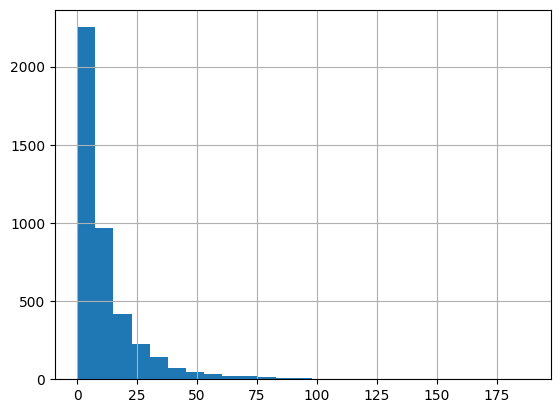

In [34]:
website_osm_distance[website_osm_distance <= 200].hist(bins=25)

100 m look good.

### Take the locations that were not yet matched and match them spatially

Turns out that Netto Salling uses bad geocoded coordinates and 100 m is too small for them.

In [35]:
MAX_DISTANCE=250

In [36]:
official_not_yet_matched = official_both[~(official_both.index.isin(website_match["official_id"]))].copy()
official_not_yet_matched["geometry_official"] = official_not_yet_matched["geometry"]
official_not_yet_matched = official_not_yet_matched.to_crs(METER_CRS)
osm_not_yet_matched = osm_supermarkets[~(osm_supermarkets.index.isin(website_match["osm_id"]))].copy()
osm_not_yet_matched["geometry_osm"] = osm_not_yet_matched["geometry"]
osm_not_yet_matched = osm_not_yet_matched.to_crs(METER_CRS)

In [37]:
spatial_match = official_not_yet_matched.sjoin_nearest(osm_not_yet_matched, lsuffix="official", rsuffix="osm", max_distance=MAX_DISTANCE).drop(columns=["geometry"])
spatial_match

,ref,shop_official,@source_uri,@spider,addr:street_address,addr:city,addr:state,addr:postcode,addr:country,name_official,...,osm_id,timestamp,name_osm,brand_osm,brand:wikidata_osm,not:brand:wikidata,operator,shop_osm,website_osm,geometry_osm
official_id,,,,,,,,,,,,,,,,,,,,,
pRrDfj3neiHjEmcAbW290oEitA8=,9041,supermarket,https://www.netto-online.de/filialen/viersen/l...,netto_de,Löhstr. 21 (Löhcenter),Viersen,Nordrhein-Westfalen,41747,DE,Netto Marken-Discount,...,node/5868154711,2024-10-08T16:25:22Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/viersen/l...,POINT (6.38485 51.2574)
Yxj8e6XyYduLrHYvAqBnDlOflgQ=,8712,supermarket,https://www.netto-online.de/filialen/leipzig/r...,netto_de,Rödelstr. 31,Leipzig,Sachsen,04229,DE,Netto Marken-Discount,...,way/24309731,2024-06-19T18:14:11Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/leipzig/r...,POINT (12.34124 51.31814)
ZGiAbrUF6HouPddFcZSCHxoFuyw=,8698,supermarket,https://www.netto-online.de/filialen/weida/neu...,netto_de,Neustädter Str. 77,Weida,Thüringen,07570,DE,Netto Marken-Discount,...,way/126365467,2025-02-19T03:44:11Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,Netto Marken-Discount AG & Co. KG,supermarket,NaN,POINT (12.04373 50.7765)
1d3mtrQYXQiZjQ5_WnZopEH6978=,8009,supermarket,https://www.netto-online.de/filialen/fischen/a...,netto_de,Am Anger 1,Fischen,Bayern,87538,DE,Netto City,...,node/270409339,2024-08-26T16:11:59Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,NaN,POINT (10.27228 47.45792)
lbXkUrqWKisziN3O-C8EFxHLShE=,7935,supermarket,https://www.netto-online.de/filialen/buchen/ho...,netto_de,Hollergasse 15,Buchen,Baden-Württemberg,74722,DE,Netto Marken-Discount,...,way/107713354,2021-12-15T18:13:13Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,NaN,POINT (9.32056 49.52122)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VTfhMOELQDzoTVcw8My-CUFhIbU=,780b1080-3dba-47f0-abd6-ca5d9a4b6442,supermarket,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,Güterfelder Damm 65,Stahnsdorf,NaN,14532,DE,Netto,...,way/180176140,2021-03-23T19:41:28Z,Netto,Netto,Q552652,NaN,NaN,supermarket,NaN,POINT (13.21022 52.37975)
Dd5rzD1pOmgO32OpIrGW1_jfA84=,24f46965-487c-46d2-873a-d28379135cbf,supermarket,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,Rigaer Straße 2,Hennigsdorf,NaN,16761,DE,Netto,...,way/31727346,2024-10-28T19:28:50Z,Netto,Netto,Q552652,NaN,Netto ApS & Co. KG Stavenhagen,supermarket,https://www.netto.de,POINT (13.19552 52.65119)
g2tXdEtVOyjgd2UsAeTTVwYbahc=,3d09ce98-0e02-4a10-a758-2b9725908710,supermarket,https://api.sallinggroup.com/v2/stores?brand=n...,netto_salling,Pressentinstrasse 63b,Rostock Gehlsdorf,NaN,18147,DE,Netto,...,node/3241832329,2023-07-28T05:48:07Z,Netto,Netto,Q552652,NaN,NaN,supermarket,NaN,POINT (12.11505 54.10439)


In [38]:
matched = pd.concat([website_match, spatial_match.reset_index(drop=False)]).reset_index(drop=True)

In [39]:
matched["website"] = matched["website"].combine_first(matched.pop("website_official"))

In [40]:
len(matched)

4626

In [41]:
unmatched_official = official_both[~(official_both.index.isin(matched["official_id"]))]
unmatched_official

,ref,shop,@source_uri,@spider,addr:street_address,addr:city,addr:state,addr:postcode,addr:country,name,website,contact:facebook,opening_hours,brand,geometry,branch,phone,brand:wikidata,nsi_id
official_id,,,,,,,,,,,,,,,,,,,
S69eh7wjGujmfEQu8gP2MrpYbLM=,6471,supermarket,https://www.netto-online.de/filialen/duisburg/...,netto_de,Wanheimerstr. 23,Duisburg,Nordrhein-Westfalen,47053,DE,Netto Marken-Discount,https://www.netto-online.de/filialen/duisburg/...,https://www.facebook.com/nettomarkendiscount/,Mo-Sa 07:00-22:00,Netto Marken-Discount,POINT (6.75451 51.42156),NaN,NaN,NaN,NaN
teCRl7pHMTzhn48YiOehB2G4JN4=,5948,supermarket,https://www.netto-online.de/filialen/deissling...,netto_de,Römerstraße 158,Deißlingen-Lauffen,<nicht bekannt>,78652,DE,Netto Marken-Discount,https://www.netto-online.de/filialen/deissling...,https://www.facebook.com/nettomarkendiscount/,Mo-Sa 07:00-20:00,Netto Marken-Discount,POINT (8.63381 48.12561),NaN,NaN,NaN,NaN
BarDlgjvpjR-HRzfvU_PNIEg6_4=,5947,supermarket,https://www.netto-online.de/filialen/erligheim...,netto_de,Im Remsel 1,Erligheim,Baden-Württemberg,74391,DE,Netto Marken-Discount,https://www.netto-online.de/filialen/erligheim...,https://www.facebook.com/nettomarkendiscount/,Mo-Sa 07:00-20:00,Netto Marken-Discount,POINT (9.09569 49.02374),NaN,NaN,NaN,NaN
2xU98GO7lhcwmDeUlpW5vV3r5Nk=,5945,supermarket,https://www.netto-online.de/filialen/demmin/ja...,netto_de,Jarmener Chaussee 5 a,Demmin,Mecklenburg-Vorpommern,17109,DE,Netto Marken-Discount,https://www.netto-online.de/filialen/demmin/ja...,https://www.facebook.com/nettomarkendiscount/,Mo-Sa 07:00-20:00,Netto Marken-Discount,POINT (13.0791 53.90379),NaN,NaN,NaN,NaN
pNcmxqKTaebinX2D8J-CiG-AILw=,5944,supermarket,https://www.netto-online.de/filialen/floeha/ba...,netto_de,Bahnhofstraße 7 a,Flöha,Sachsen,09557,DE,Netto Marken-Discount,https://www.netto-online.de/filialen/floeha/ba...,https://www.facebook.com/nettomarkendiscount/,Mo-Sa 07:00-20:00,Netto Marken-Discount,POINT (13.07451 50.85584),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HmAcPm6enjhDsy3zZgmsvgGvyl0=,2188,beverages,https://www.netto-online.de/filialen/witzenhau...,netto_de,Am Eschenbornrasen 27,Witzenhausen,Hessen,37213,DE,Netto Getränke-Discount,https://www.netto-online.de/filialen/witzenhau...,https://www.facebook.com/nettomarkendiscount/,Mo-Sa 07:00-21:00,Netto Getränke-Discount,POINT (9.86228 51.33648),NaN,NaN,NaN,NaN
D74mkFRRntl8NnZi51wES1w01z4=,2185,beverages,https://www.netto-online.de/filialen/laatzen/h...,netto_de,Hildsheimer Str. 47,Laatzen,Niedersachsen,30880,DE,Netto Getränke-Discount,https://www.netto-online.de/filialen/laatzen/h...,https://www.facebook.com/nettomarkendiscount/,Mo-Sa 08:00-21:00,Netto Getränke-Discount,POINT (9.79073 52.31794),NaN,NaN,NaN,NaN
NKr7zsDPTvM3KtRLZWuP7fIb4CU=,2184,supermarket,https://www.netto-online.de/filialen/bad-wildu...,netto_de,Breiter Hagen 6 (EKZ Fürstenga,Bad Wildungen,Hessen,34537,DE,Netto Marken-Discount,https://www.netto-online.de/filialen/bad-wildu...,https://www.facebook.com/nettomarkendiscount/,Mo-Sa 07:00-20:00,Netto Marken-Discount,POINT (9.12007 51.11915),NaN,NaN,NaN,NaN


In [42]:
unmatched_osm = osm_supermarkets[~(osm_supermarkets.index.isin(matched["osm_id"]))]
unmatched_osm

,geometry,timestamp,name,brand,brand:wikidata,not:brand:wikidata,operator,shop,website
osm_id,,,,,,,,,
node/12080067241,POINT (8.22166 48.29563),2024-07-29T12:54:20Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,NaN
node/341709693,POINT (10.92064 49.90054),2024-02-28T15:47:09Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialfinder
node/7147142368,POINT (12.485 48.64648),2024-08-30T17:34:36Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de
node/9530398685,POINT (6.35701 50.92147),2024-06-22T09:30:21Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,NaN
node/8812781101,POINT (7.11051 51.51455),2024-08-14T00:55:17Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de
node/602166572,POINT (8.73713 50.45794),2025-02-23T21:17:49Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/muenzenbe...
node/2302251146,POINT (8.14929 52.83224),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/emstek/ba...
node/1483982181,POINT (10.67212 50.60171),2025-02-05T13:21:47Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,NaN
node/1249018360,POINT (12.01412 50.04184),2024-10-08T16:25:19Z,Netto Marken-Discount,Netto Marken-Discount,Q879858,NaN,NaN,supermarket,https://www.netto-online.de/filialen/wunsiedel...


# Stats about the matching and non-matching entries

We have the following cases:

* official red matched (website or spatially) to clearly red
* official red matched to clearly black
* official red matched to unclear
* official red unmatched
* official black matched to clearly black
* official black matched to clearly red
* official black matched to unclear
* official black unmatched
* clearly red unmatched
* clearly black unmatched
* unclear unmatched

“Official red matched to clearly red” and “Official black matched to clearly black” are the desired states. The rest should be looked into.

In [43]:
official_red_matched_clearly_red = matched[(matched["official_id"].isin(official_red.index)) & (matched["osm_id"].isin(osm_supermarkets[clearly_red].index))]
official_red_matched_clearly_black = matched[(matched["official_id"].isin(official_red.index)) & (matched["osm_id"].isin(osm_supermarkets[clearly_black].index))]
official_red_matched_unclear = matched[(matched["official_id"].isin(official_red.index)) & (matched["osm_id"].isin(osm_supermarkets[unclear].index))]
official_red_unmatched = unmatched_official[unmatched_official.index.isin(official_red.index)]
official_black_matched_clearly_red = matched[(matched["official_id"].isin(official_black.index)) & (matched["osm_id"].isin(osm_supermarkets[clearly_red].index))]
official_black_matched_clearly_black = matched[(matched["official_id"].isin(official_black.index)) & (matched["osm_id"].isin(osm_supermarkets[clearly_black].index))]
official_black_matched_unclear = matched[(matched["official_id"].isin(official_black.index)) & (matched["osm_id"].isin(osm_supermarkets[unclear].index))]
official_black_unmatched = unmatched_official[unmatched_official.index.isin(official_black.index)]
clearly_red_unmatched = unmatched_osm[unmatched_osm.index.isin(osm_supermarkets[clearly_red].index)]
clearly_black_unmatched = unmatched_osm[unmatched_osm.index.isin(osm_supermarkets[clearly_black].index)]
unclear_unmatched = unmatched_osm[unmatched_osm.index.isin(osm_supermarkets[unclear].index)]

In [44]:
case_sizes = pd.DataFrame([
    ["Official red matched to clearly red ✅", len(official_red_matched_clearly_red)],
    ["Official red matched to clearly black", len(official_red_matched_clearly_black)],
    ["Official red matched to unclear", len(official_red_matched_unclear)],
    ["Official red not matched", len(official_red_unmatched)],
    ["Official black matched to clearly red", len(official_black_matched_clearly_red)],
    ["Official black matched to clearly black ✅", len(official_black_matched_clearly_black)],
    ["Official black matched to unclear", len(official_black_matched_unclear)],
    ["Official black not matched", len(official_black_unmatched)],
    ["Clearly red in OSM, not found in official data", len(clearly_red_unmatched)],
    ["Clearly black in OSM, not found in official data", len(clearly_black_unmatched)],
    ["Unclear in OSM, not found in official data", len(unclear_unmatched)],
], columns=["Description", "count"])
case_sizes

,Description,count
0,Official red matched to clearly red ✅,4285
1,Official red matched to clearly black,0
2,Official red matched to unclear,1
3,Official red not matched,116
4,Official black matched to clearly red,0
5,Official black matched to clearly black ✅,340
6,Official black matched to unclear,0
7,Official black not matched,0
8,"Clearly red in OSM, not found in official data",31
9,"Clearly black in OSM, not found in official data",0


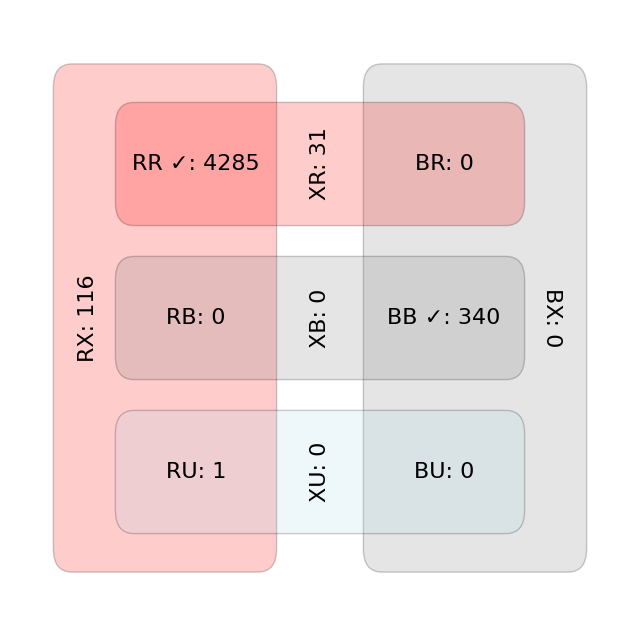

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))

# Define rectangles: (x, y, width, height, color)
rectangles = [
    (1, 1, 3, 6, 'red'),
    (6, 1, 3, 6, 'gray'),
    (2, 1.5, 6, 1, 'lightblue'),
    (2, 3.5, 6, 1, 'gray'),
    (2, 5.5, 6, 1, 'red'),
]

for x, y, width, height, color in rectangles:
    rectangle = FancyBboxPatch((x, y), width, height, boxstyle='round', facecolor=color, edgecolor='black', alpha=0.2)
    ax.add_patch(rectangle)

labels = [
    (3, 6, 0, f"RR ✓: {len(official_red_matched_clearly_red)}"),
    (3, 4, 0, f"RB: {len(official_red_matched_clearly_black)}"),
    (3, 2, 0, f"RU: {len(official_red_matched_unclear)}"),
    (1.25, 4, 90, f"RX: {len(official_red_unmatched)}"),
    (7, 6, 0, f"BR: {len(official_black_matched_clearly_red)}"),
    (7, 4, 0, f"BB ✓: {len(official_black_matched_clearly_black)}"),
    (7, 2, 0, f"BU: {len(official_black_matched_unclear)}"),
    (8.75, 4, 270, f"BX: {len(official_black_unmatched)}"),
    (5, 6, 90, f"XR: {len(clearly_red_unmatched)}"),
    (5, 4, 90, f"XB: {len(clearly_black_unmatched)}"),
    (5, 2, 90, f"XU: {len(unclear_unmatched)}"),
]

for x, y, angle, label in labels:
    ax.annotate(label, (x, y), rotation=angle, size=16, ha='center', va='center')
    
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)
ax.axis("off")

plt.savefig("matching_diagram.png")
plt.show()

## Export as Markdown files

In [46]:
export_columns = ["ref", "shop_official", "shop_osm", "addr:street_address", "addr:postcode", "addr:city", "website",
                  "osm_id", "timestamp"]

In [47]:
export_matched = {
    "official_red_matched_clearly_red": official_red_matched_clearly_red,
    "official_red_matched_clearly_black": official_red_matched_clearly_black,
    "official_red_matched_unclear": official_red_matched_unclear,
    "official_black_matched_clearly_red": official_black_matched_clearly_red,
    "official_black_matched_clearly_black": official_black_matched_clearly_black,
    "official_black_matched_unclear": official_black_matched_unclear,
}

In [48]:
for filename, result in export_matched.items():
    formatted = result[export_columns].copy()
    formatted["website"] = "[🌐](" + formatted["website"] + ")"
    formatted["osm_id"] = osm_object_link(result["osm_id"], result["geometry_official"])
    with open(f"{filename}.md", "w") as outfile:
        outfile.write(formatted.to_markdown(index=False))

In [49]:
export_unmatched_official = {
    "official_red_unmatched": official_red_unmatched,
    "official_black_unmatched": official_black_unmatched,
}

In [50]:
export_columns = ["ref", "shop", "addr:street_address", "addr:postcode", "addr:city", "website"]

In [51]:
def geo_to_link(point):
    return (
        "[" + point.y.astype(str) + ", " + point.x.astype(str) + "](https://www.openstreetmap.org/" +
        "?mlat=" + point.y.astype(str) + "&mlon=" + point.x.astype(str) +
        "#map=19/" + point.y.astype(str) + "/" + point.x.astype(str) + ")"
    )

In [52]:
for filename, result in export_unmatched_official.items():
    formatted = result[export_columns].copy()
    formatted["geometry"] = geo_to_link(result["geometry"])
    with open(f"{filename}.md", "w") as outfile:
        outfile.write(formatted.to_markdown(index=False))

In [53]:
export_unmatched_osm = {
    "clearly_red_unmatched": clearly_red_unmatched,
    "clearly_black_unmatched": clearly_black_unmatched,
    "unclear_unmatched": unclear_unmatched,
}

In [54]:
export_columns = ["osm_id", "shop", "name", "brand", "brand:wikidata", "timestamp"]

In [55]:
for filename, result in export_unmatched_osm.items():
    formatted = result.reset_index()[export_columns].copy()
    formatted["osm_id"] = "[" + formatted["osm_id"] + "](https://www.openstreetmap.org/" + formatted["osm_id"] + ")"
    with open(f"{filename}.md", "w") as outfile:
        outfile.write(formatted.to_markdown(index=False))